#Import Relevant Libraries


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import TextVectorization, Bidirectional
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import nltk

# Import untuk visualisasi dan evaluasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shiro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shiro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# === 1. LOAD DATASETS ===
print("Loading datasets...")
cnn_df = pd.read_csv("dataset/cnn.csv")
kompas_df = pd.read_csv("dataset/kompas.csv")
tempo_df = pd.read_csv("dataset/tempo.csv")
turnbackhoax_df = pd.read_csv("dataset/turnbackhoax.csv")

print(f"CNN shape: {cnn_df.shape}")
print(f"Kompas shape: {kompas_df.shape}")
print(f"Tempo shape: {tempo_df.shape}")
print(f"TurnBackHoax shape: {turnbackhoax_df.shape}")

Loading datasets...
CNN shape: (9630, 8)
Kompas shape: (4750, 8)
Tempo shape: (6592, 8)
TurnBackHoax shape: (10381, 10)


In [4]:
def standardize_columns(df, dataset_name):
    """Standardize column names across datasets"""
    df = df.copy()
    
    print(f"\n--- Standardizing {dataset_name} ---")
    print(f"Original columns: {df.columns.tolist()}")
    
    # Rename columns to standard format
    column_mapping = {}
    
    # Find title column - semua dataset pakai 'Title'
    if 'Title' in df.columns:
        column_mapping['Title'] = 'title'
    elif 'title' in df.columns:
        column_mapping['title'] = 'title'
    
    # Find text/content column - berbeda per dataset
    if 'Cleaned_Text' in df.columns:  # CNN
        column_mapping['Cleaned_Text'] = 'text'
    elif 'Cleaned_Narasi' in df.columns:  # TurnBackHoax
        column_mapping['Cleaned_Narasi'] = 'text'
    elif 'text_new' in df.columns:  # Kompas & Tempo
        column_mapping['text_new'] = 'text'
    elif 'FullText' in df.columns:  # Fallback ke FullText jika cleaned tidak ada
        column_mapping['FullText'] = 'text'
    
    # Find label column - semua dataset pakai 'hoax'
    if 'hoax' in df.columns:
        column_mapping['hoax'] = 'label'
    elif 'label' in df.columns:
        column_mapping['label'] = 'label'
    
    print(f"Column mapping: {column_mapping}")
    
    # Apply renaming
    df = df.rename(columns=column_mapping)
    
    # Check for missing required columns
    required_cols = ['title', 'text', 'label']
    available_cols = []
    
    for col in required_cols:
        if col in df.columns:
            available_cols.append(col)
        else:
            print(f"WARNING: '{col}' column not found in {dataset_name}!")
    
    if len(available_cols) < 3:
        print(f"ERROR: Missing required columns in {dataset_name}!")
        print(f"Available after mapping: {df.columns.tolist()}")
        return pd.DataFrame()  # Return empty dataframe
    
    # Keep only necessary columns
    df = df[available_cols].copy()
    
    # Fill missing values
    df['title'] = df['title'].fillna('')
    df['text'] = df['text'].fillna('')
    
    # Add source column
    df['source'] = dataset_name
    
    print(f"Final columns: {df.columns.tolist()}")
    print(f"Final shape: {df.shape}")
    
    return df

In [5]:
# === 2. STANDARDIZE ALL DATASETS ===
print("=" * 50)
print("STANDARDIZING DATASETS")
print("=" * 50)

cnn_df = standardize_columns(cnn_df, 'CNN')
kompas_df = standardize_columns(kompas_df, 'Kompas')
tempo_df = standardize_columns(tempo_df, 'Tempo')
turnbackhoax_df = standardize_columns(turnbackhoax_df, 'TurnBackHoax')

# === 3. MERGE ALL DATASETS ===
print("\n" + "=" * 50)
print("MERGING DATASETS")
print("=" * 50)

# Remove empty dataframes
dfs_to_merge = []
for name, df in [('CNN', cnn_df), ('Kompas', kompas_df), ('Tempo', tempo_df), ('TurnBackHoax', turnbackhoax_df)]:
    if not df.empty:
        dfs_to_merge.append(df)
        print(f"{name}: {df.shape}")
    else:
        print(f"{name}: EMPTY - Skipped")

if len(dfs_to_merge) == 0:
    print("ERROR: No valid datasets to merge!")
else:
    news_df = pd.concat(dfs_to_merge, ignore_index=True)
    print(f"\nCombined dataset shape: {news_df.shape}")
    print(f"Combined columns: {news_df.columns.tolist()}")
    
    # === 4. CHECK LABEL DISTRIBUTION ===
    print("\n" + "=" * 50)
    print("LABEL DISTRIBUTION")
    print("=" * 50)
    print(f"Unique labels: {news_df['label'].unique()}")
    print(f"Label value counts:\n{news_df['label'].value_counts()}")
    
    # === 5. SEPARATE INTO FAKE AND REAL ===
    print("\n" + "=" * 50)
    print("SEPARATING FAKE AND REAL NEWS")
    print("=" * 50)
    
    fake_df = news_df[news_df['label'] == 1].copy()  # hoax=1 adalah fake
    real_df = news_df[news_df['label'] == 0].copy()  # hoax=0 adalah real
    
    print(f"Fake news count (label=1): {len(fake_df)}")
    print(f"Real news count (label=0): {len(real_df)}")
    
    # Save to CSV
    if len(fake_df) > 0:
        fake_df.to_csv("dataset/Fake.csv", index=False)
        print("\n✓ Saved dataset/Fake.csv")
    else:
        print("\nWARNING: No fake news to save!")
    
    if len(real_df) > 0:
        real_df.to_csv("dataset/Real.csv", index=False)
        print("✓ Saved dataset/Real.csv")
    else:
        print("WARNING: No real news to save!")
    
    print("\n" + "=" * 50)
    print("COMPLETED")
    print("=" * 50)

STANDARDIZING DATASETS

--- Standardizing CNN ---
Original columns: ['Title', 'Timestamp', 'FullText', 'Tags', 'Author', 'Url', 'Cleaned_Text', 'hoax']
Column mapping: {'Title': 'title', 'Cleaned_Text': 'text', 'hoax': 'label'}
Final columns: ['title', 'text', 'label', 'source']
Final shape: (9630, 4)

--- Standardizing Kompas ---
Original columns: ['Title', 'Timestamp', 'FullText', 'Tags', 'Author', 'Url', 'text_new', 'hoax']
Column mapping: {'Title': 'title', 'text_new': 'text', 'hoax': 'label'}
Final columns: ['title', 'text', 'label', 'source']
Final shape: (4750, 4)

--- Standardizing Tempo ---
Original columns: ['Title', 'Timestamp', 'FullText', 'Tags', 'Author', 'Url', 'text_new', 'hoax']
Column mapping: {'Title': 'title', 'text_new': 'text', 'hoax': 'label'}
Final columns: ['title', 'text', 'label', 'source']
Final shape: (6592, 4)

--- Standardizing TurnBackHoax ---
Original columns: ['Title', 'Timestamp', 'FullText', 'Tags', 'Author', 'Url', 'politik', 'Raw_Narasi', 'Cleaned_

## Plot WordCloud

In [6]:
# Function to plot WordCloud

def generate_wordcloud_subplot(df, label_value, subplot_position, max_words=1000, width=800, height=400):
    """
    Generate a word cloud for a specific label value and display it in a subplot.

    Args:
        df (DataFrame): The DataFrame containing text data and labels.
        label_value (int): The label value for which to generate the word cloud.
        subplot_position (int): The position of the subplot where the word cloud will be displayed.
        max_words (int, optional): Maximum number of words to include in the word cloud. Default is 1000.
        width (int, optional): Width of the word cloud image. Default is 800.
        height (int, optional): Height of the word cloud image. Default is 400.

    Returns:
        None
    """

    # Select the text subset for the specified label value
    text_subset = df[df['label'] == label_value]['text']
    
    # Check if text_subset is not empty
    if text_subset.empty:
        print(f"Warning: No data found for label {label_value}")
        return
    
    # Combine all text
    combined_text = " ".join(text_subset.astype(str))
    
    # Check if combined_text is empty
    if not combined_text.strip():
        print(f"Warning: No text content for label {label_value}")
        return

    # Define stopwords (English + Indonesian)
    stop_words = set(STOPWORDS)
    indonesian_stopwords = {'dan', 'di', 'ke', 'dari', 'yang', 'untuk', 'pada', 
                            'dengan', 'ini', 'itu', 'adalah', 'akan', 'atau', 
                            'oleh', 'tidak', 'ada', 'sebagai', 'dalam', 'juga',
                            'telah', 'dapat', 'saat', 'saja', 'karena', 'sudah',
                            'kata', 'berita', 'news', 'cnn', 'kompas', 'tempo'}
    stop_words.update(indonesian_stopwords)

    # Create a WordCloud object with specified parameters
    wc = WordCloud(
        max_words=max_words, 
        width=width, 
        height=height, 
        stopwords=stop_words,
        background_color='white',
        colormap='viridis',
        relative_scaling=0.5,
        min_font_size=10
    )

    # Generate the word cloud from the combined text
    wc.generate(combined_text)

    # Create a subplot and display the word cloud
    plt.subplot(subplot_position)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')  # Hide axes

    # Set the title for the word cloud plot
    # Label 1 = Fake (hoax), Label 0 = Real
    title = f'WordCloud for Label {label_value} ({"Fake/Hoax" if label_value == 1 else "Real/Non-Hoax"})'
    plt.title(title, fontsize=14, fontweight='bold')

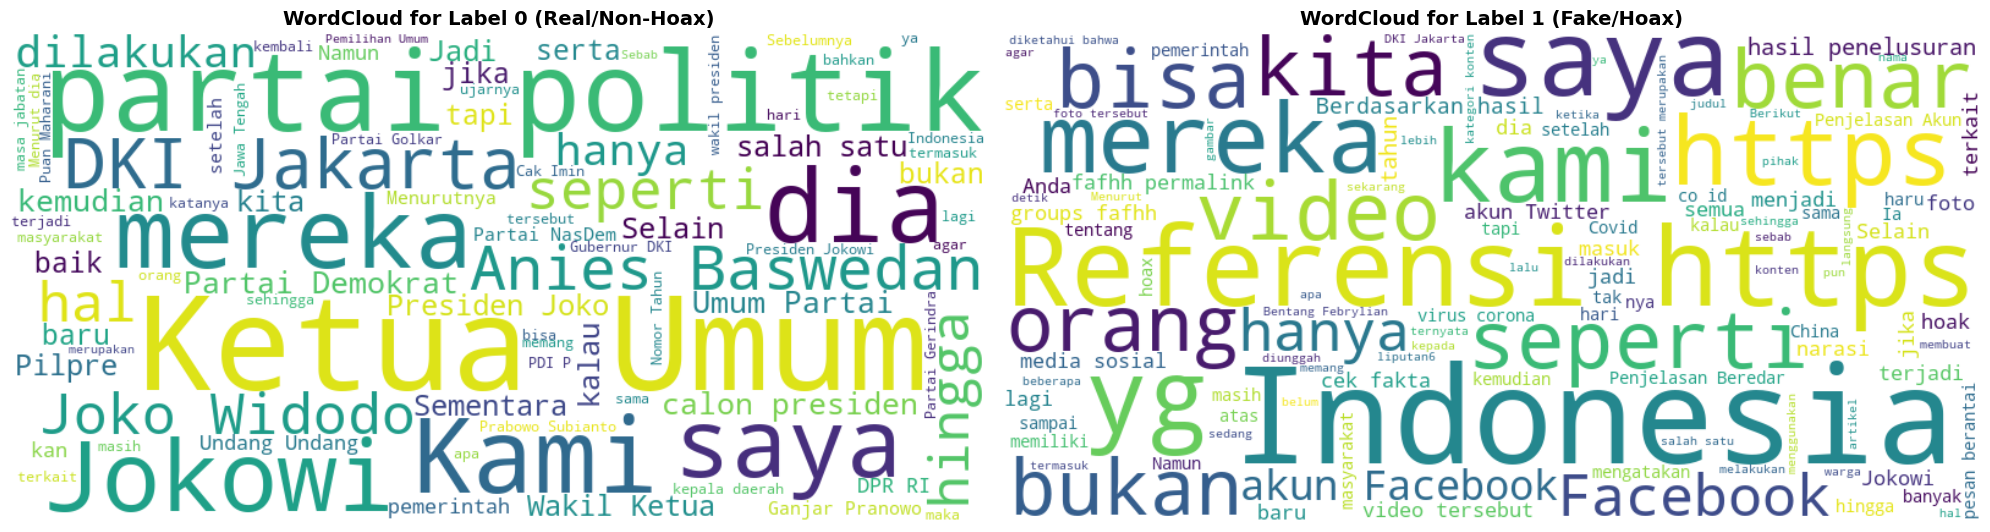

In [7]:
if 'news_df' in locals() and not news_df.empty:
    # Create a 1x2 grid of subplots
    plt.figure(figsize=(20, 10))

    # Generate WordCloud for label_value = 0 (Real News)
    generate_wordcloud_subplot(news_df, label_value=0, subplot_position=121)

    # Generate WordCloud for label_value = 1 (Fake News)
    generate_wordcloud_subplot(news_df, label_value=1, subplot_position=122)

    plt.tight_layout()
    plt.show()
else:
    print("Error: news_df not found. Please run the data loading cells first.")

## Plot Confusion Matrix


In [8]:
def plot_confusion_matrix(y_true, y_pred, labels=["Real", "Fake"], figsize=(8, 6)):
    """
    Plot confusion matrix untuk deteksi berita hoax Indonesia.
    
    Dataset: 
    - Real (label=0): Berita dari CNN, Kompas, Tempo
    - Fake (label=1): Berita hoax dari TurnBackHoax
    
    Args:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
        labels (list): Class labels ["Real", "Fake"]
        figsize (tuple): Figure size
    """
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Create annotations with both count and percentage
    annot_labels = np.array([[f'{count}\n({percent:.1f}%)' 
                              for count, percent in zip(row_count, row_percent)]
                             for row_count, row_percent in zip(cm, cm_percent)])
    
    # Plot heatmap
    sns.heatmap(cm_df, annot=annot_labels, fmt='', cmap="Blues", 
                cbar=True, square=True,
                annot_kws={"size": 12, "weight": "bold"},
                linewidths=2, linecolor='white',
                cbar_kws={'label': 'Jumlah Prediksi'})
    
    plt.xlabel("Predicted Label", fontsize=13, fontweight='bold')
    plt.ylabel("True Label", fontsize=13, fontweight='bold')
    plt.title("Confusion Matrix - Deteksi Berita Hoax Indonesia", 
              fontsize=15, fontweight='bold', pad=20)
    
    # Add labels explanation
    plt.text(0.5, -0.15, 
             'Label 0 = Real (CNN/Kompas/Tempo) | Label 1 = Fake (Hoax)', 
             ha='center', transform=plt.gca().transAxes,
             fontsize=10, style='italic', color='gray')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\n" + "="*60)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*60)
    print(f"True Negatives (Real predicted as Real):  {cm[0,0]:,}")
    print(f"False Positives (Real predicted as Fake): {cm[0,1]:,}")
    print(f"False Negatives (Fake predicted as Real): {cm[1,0]:,}")
    print(f"True Positives (Fake predicted as Fake):  {cm[1,1]:,}")
    print("="*60)

## Plot Precision/Recall Results

In [9]:
def plot_model_results(results_df, model_name="Model"):
    """
    Visualize model performance metrics in bar chart.
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    values = []
    
    for metric in metrics:
        val = results_df[metric].iloc[0]
        if isinstance(val, str):
            val = val.rstrip('%')
            values.append(float(val))
        else:
            values.append(float(val) * 100 if metric != 'accuracy' else float(val))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
    bars = ax.bar(metrics, values, color=colors, 
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        label = f'{val:.2f}%' if metrics[bars.index(bar)] == 'accuracy' else f'{val:.3f}'
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                label, ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Score (%)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
    ax.set_title(f'{model_name} - Performance Metrics\nDeteksi Berita Hoax Indonesia', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim(0, 110)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()


# Exploratory Data Analysis

## Load Data

In [10]:
# Load Data

fake_df = pd.read_csv("./dataset/Fake.csv")
true_df = pd.read_csv("./dataset/Real.csv")

In [11]:
fake_df.head()

,title,text,label,source
0,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1,TurnBackHoax
1,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...,ini bener gasih?? Ya Allah gimna keadaan pa ha...,1,TurnBackHoax
2,[SALAH] GAMBAR MEGAWATI DAN PUAN BERMAIN SLOT,Nenek lampir pemimpin partai banteng bercula s...,1,TurnBackHoax
3,[SALAH] JONATHAN LATUMAHINA SEORANG NASRANI DA...,gerombolan kulup banyak menyusup ke ormas2 isl...,1,TurnBackHoax
4,[SALAH] PESAN WHATSAPP DARI BMKG YANG KABARKAN...,NaN,1,TurnBackHoax


In [12]:
true_df.head()

,title,text,label,source
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,CNN
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,CNN
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,CNN
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapres,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,CNN
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,CNN


In [13]:
fake_df.shape, true_df.shape

((10381, 4), (20972, 4))

## Merge Data

In [14]:
# Merge data

# Set label 0 to fake and 1 to real
fake_df["label"] = 0
true_df["label"] = 1

news_df = pd.concat([fake_df, true_df])
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31353 entries, 0 to 20971
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   31332 non-null  object
 1   text    27447 non-null  object
 2   label   31353 non-null  int64 
 3   source  31353 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


## Duplicated Rows

In [15]:
# Checking duplicate rows

duplicate = news_df[news_df.duplicated()]

print(f"Nr. of Duplicated Rows :{duplicate.shape[0]} rows")

# Print the resultant Dataframe
duplicate

Nr. of Duplicated Rows :34 rows


,title,text,label,source
770,[SALAH] Perubahan Tarif Transaksi BRI,Sehubungan dengan meningkatnya kualitas dan ke...,0,TurnBackHoax
2964,[SALAH] Foto Masjid Meledak Saat Waktu Sholat...,NaN,0,TurnBackHoax
4240,[SALAH] 6 Ormas Ini Resmi Dibubarkan Pemerintah,Ini baru berita top!!! :point_down: http://m.a...,0,TurnBackHoax
5492,[SALAH] Foto Uya Kuya Menghipnotis Wapres Mar...,NaN,0,TurnBackHoax
5552,[SALAH] Anies Sebut Solusi Banjir adalah Tingg...,SOLUSI BANJIR ITU MUDAH TINGGAL TUNGGU MUSIM K...,0,TurnBackHoax
5601,[SALAH] Istilah Kadrun Berasal dari PKI,KADRUN itu dari PKI Barokallahu fiik Habib @hu...,0,TurnBackHoax
7957,"[BENAR] NUNGGAK BPJS TAK BISA URUS SIM-STNK, P...","Narasi klarifikasi: Dirut BPJS Kesehatan, Fach...",0,TurnBackHoax
8331,[SALAH] Didit Prabowo akan menikahkan para gay,NaN,0,TurnBackHoax
8690,[SALAH] Nomor IMEI di Ponsel Bisa Disadap Polisi,Ketik aja *#06# di fitur Call. Kalau keluar 1 ...,0,TurnBackHoax
8836,[SALAH] Beginilah Caranya China Menghancurkan...,NaN,0,TurnBackHoax


In [16]:
# Removing duplicates

# Get the number of rows before removing duplicates
num_rows_before = len(news_df)

# Drop duplicate rows based on all columns
news_df = news_df.drop_duplicates()

# Get the number of rows after removing duplicates
num_rows_after = len(news_df)

# Print the number of rows before and after
print(f"Number of rows before removing duplicates: {num_rows_before}")
print(f"Number of rows after removing duplicates: {num_rows_after}")

Number of rows before removing duplicates: 31353
Number of rows after removing duplicates: 31319


## Missing Data

In [17]:
# Check for missing data

print('Number of NaN values present: ' + str(news_df.isnull().sum().sum()))

Number of NaN values present: 3881


In [18]:
# Calculating missing values in the dataset

missing_values = news_df.isnull().sum()

missing_per = (missing_values/news_df.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True)
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)

missing_table

,Total Missing Values,Missing %
title,1,0.003193
text,3880,12.388646
label,0,0.000000
source,0,0.000000


## Unique Values

It is interesting to see that around 6'000 titles and texts are repetated but have different labels

In [19]:
# Check the Nr. of Unique Values

column_dict = {
    'Column Name': [],
    'Unique Values': []
}

for column in news_df.columns:
    unique_values = news_df[column].nunique()
    column_dict['Column Name'].append(column)
    column_dict['Unique Values'].append(unique_values)

unique_df = pd.DataFrame(column_dict)
unique_df

,Column Name,Unique Values
0,title,31292
1,text,27431
2,label,2
3,source,4


## Plots

### Labels

In [20]:
# Check value counts

news_df['label'].value_counts()

label
1    20952
0    10367
Name: count, dtype: int64

In [21]:
# Plot labels distribution
import nbformat

# Define new colors
colors = ['#FF5733', '#33FF57']  # Custom colors

labels = ['FAKE','TRUE']
value_counts = news_df['label'].value_counts()
values = value_counts / len(news_df)

# Create the Pie chart
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.3,
    hoverinfo='label+percent',
    textinfo='percent',
    textfont_size=20,
    marker=dict(colors=colors, line=dict(color='#000000', width=2))
)])

# Update the layout
fig.update_layout(
    title="Labels Distribution",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
    width=800,
    height=600
)

# Show the figure
fig.show()

### Subjects

In [24]:
# ===================================================================
# PLOT: INTERACTIVE SOURCE DISTRIBUTION (PLOTLY)
# ===================================================================

if 'source' in news_df.columns:
    # Count by source and label
    source_counts = news_df.groupby(['source', 'label']).size().reset_index(name='count')
    
    # Create interactive bar chart
    fig = go.Figure()
    
    # Add Real (label=0) bars
    real_data = source_counts[source_counts['label'] == 0]
    fig.add_trace(go.Bar(
        x=real_data['source'],
        y=real_data['count'],
        name='Real (0)',
        marker_color='#2ecc71',
        text=real_data['count'],
        textposition='auto',
        hovertemplate='<b>%{x}</b><br>Real: %{y}<extra></extra>'
    ))
    
    # Add Fake (label=1) bars
    fake_data = source_counts[source_counts['label'] == 1]
    fig.add_trace(go.Bar(
        x=fake_data['source'],
        y=fake_data['count'],
        name='Fake (1)',
        marker_color='#e74c3c',
        text=fake_data['count'],
        textposition='auto',
        hovertemplate='<b>%{x}</b><br>Fake: %{y}<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title={
            'text': "Interactive: News Distribution by Source<br><sub>Deteksi Berita Hoax Indonesia</sub>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'color': 'white', 'family': 'Arial Black'}
        },
        xaxis_title="News Source",
        yaxis_title="Count",
        barmode='group',
        plot_bgcolor='#1e1e1e',
        paper_bgcolor='#0d0d0d',
        font=dict(color='white', size=12),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        height=500,
        width=900
    )
    
    fig.show()

### WordCloud

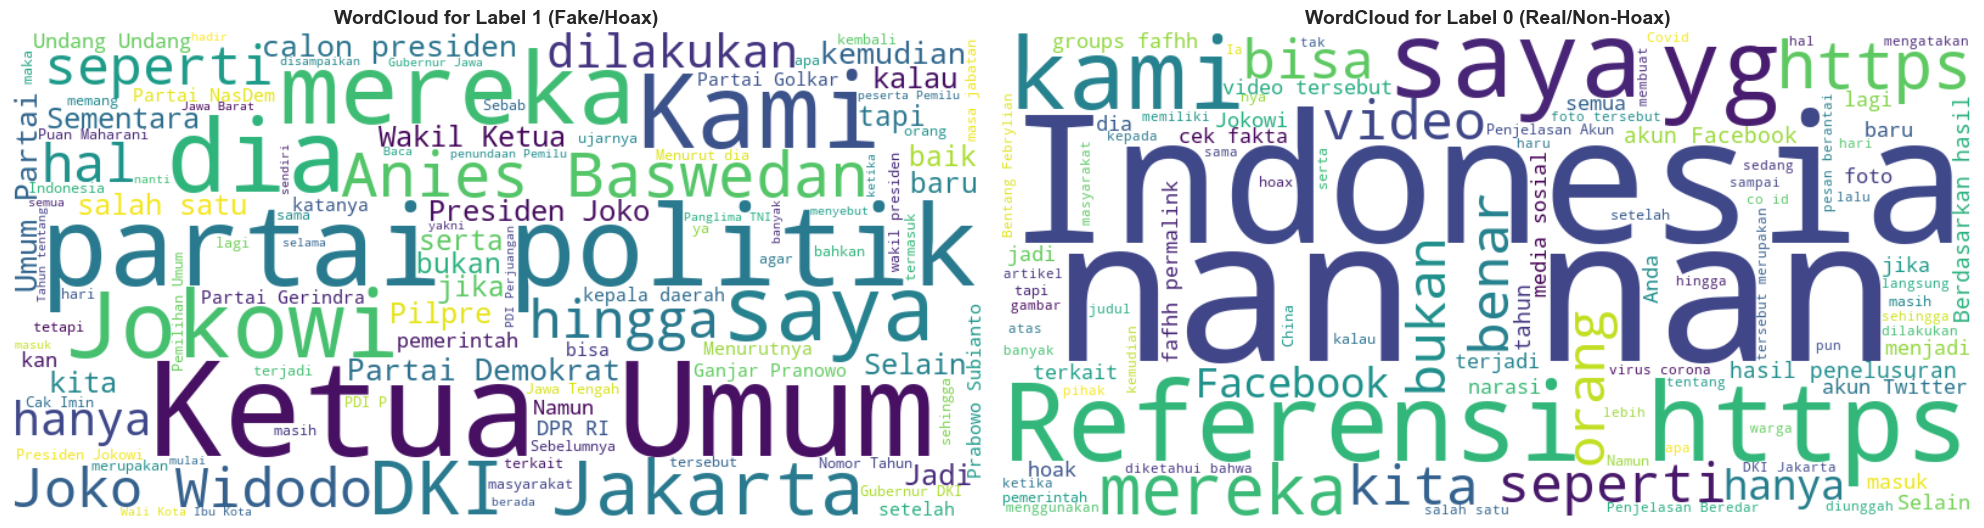

In [27]:
# Plot WordCloud

# Create a 1x2 grid of subplots
plt.figure(figsize=(20, 10))

# Generate WordCloud for label_value = 1 (subplot 1)
generate_wordcloud_subplot(news_df, label_value=1, subplot_position=121)

# Generate WordCloud for label_value = 0 (subplot 2)
generate_wordcloud_subplot(news_df, label_value=0, subplot_position=122)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

# Preprocessing

In [28]:
# Copy the df as df_model

df_model = news_df.copy()

In [29]:
df_model.head(2)

,title,text,label,source,subject
0,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,0,TurnBackHoax,TurnBackHoax
1,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...,ini bener gasih?? Ya Allah gimna keadaan pa ha...,0,TurnBackHoax,TurnBackHoax


## Select Columns

In [33]:
# Combine string columns and fill in the NaN with empty string

df_model['combined_features'] = df_model['title'] + ' ' + df_model['text']

In [34]:
# Cleaned Dataset

df_model.head()

,title,text,label,source,subject,combined_features
0,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,0,TurnBackHoax,TurnBackHoax,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...
1,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...,ini bener gasih?? Ya Allah gimna keadaan pa ha...,0,TurnBackHoax,TurnBackHoax,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...
2,[SALAH] GAMBAR MEGAWATI DAN PUAN BERMAIN SLOT,Nenek lampir pemimpin partai banteng bercula s...,0,TurnBackHoax,TurnBackHoax,[SALAH] GAMBAR MEGAWATI DAN PUAN BERMAIN SLOT ...
3,[SALAH] JONATHAN LATUMAHINA SEORANG NASRANI DA...,gerombolan kulup banyak menyusup ke ormas2 isl...,0,TurnBackHoax,TurnBackHoax,[SALAH] JONATHAN LATUMAHINA SEORANG NASRANI DA...
4,[SALAH] PESAN WHATSAPP DARI BMKG YANG KABARKAN...,NaN,0,TurnBackHoax,TurnBackHoax,NaN


## Preprocess Columns

In [36]:
# ===================================================================
# CLEAN TEXT FUNCTION (SAFE VERSION WITH ERROR HANDLING)
# ===================================================================

def clean_text(text):
    """
    Clean and preprocess text data.
    
    Args:
        text (str): Input text to clean
        
    Returns:
        str: Cleaned text
    """
    # Handle non-string values (NaN, None, float, etc.)
    if pd.isna(text) or not isinstance(text, str):
        return ''
    
    # Handle empty strings
    if not text.strip():
        return ''
    
    try:
        # Remove punctuation
        for punctuation in string.punctuation:
            text = text.replace(punctuation, ' ')

        # Convert text to lowercase
        text = text.lower()

        # Tokenize the text
        tokens = word_tokenize(text)

        # Remove non-alphabetic tokens (numbers and special characters)
        words_only = [word for word in tokens if word.isalpha()]

        # Remove stopwords (English only - untuk Indonesian, lihat catatan di bawah)
        stop_words = set(stopwords.words('english'))
        without_stopwords = [word for word in words_only if word not in stop_words]

        # Lemmatize words
        lemma = WordNetLemmatizer()
        lemmatized = [lemma.lemmatize(word) for word in without_stopwords]

        # Join the cleaned words back into a string
        cleaned = ' '.join(lemmatized)

        return cleaned
    
    except Exception as e:
        # Log error and return empty string
        print(f"Error cleaning text: {str(e)[:50]}... | Text preview: {str(text)[:30]}...")
        return ''

# ===================================================================
# APPLY CLEANING WITH PROGRESS TRACKING
# ===================================================================

print("="*60)
print("TEXT CLEANING IN PROGRESS")
print("="*60)

# Check for missing values before cleaning
print("\n1. Checking missing values before cleaning:")
print(df_model[['title', 'text', 'combined_features']].isnull().sum())

# Fill missing values first
print("\n2. Filling missing values...")
df_model['title'] = df_model['title'].fillna('')
df_model['text'] = df_model['text'].fillna('')
df_model['combined_features'] = df_model['combined_features'].fillna('')

# Check data types
print("\n3. Checking data types:")
print(df_model[['title', 'text', 'combined_features']].dtypes)

# Apply cleaning with progress tracking
print("\n4. Cleaning columns...")

print("   - Cleaning 'title'...")
df_model['title'] = df_model['title'].apply(clean_text)
print(f"     ✓ Done ({df_model['title'].notna().sum()} rows processed)")

print("   - Cleaning 'text'...")
df_model['text'] = df_model['text'].apply(clean_text)
print(f"     ✓ Done ({df_model['text'].notna().sum()} rows processed)")

print("   - Cleaning 'combined_features'...")
df_model['combined_features'] = df_model['combined_features'].apply(clean_text)
print(f"     ✓ Done ({df_model['combined_features'].notna().sum()} rows processed)")

print("\n5. Checking results:")
print(f"   - Empty titles: {(df_model['title'] == '').sum()}")
print(f"   - Empty texts: {(df_model['text'] == '').sum()}")
print(f"   - Empty combined_features: {(df_model['combined_features'] == '').sum()}")

print("\n" + "="*60)
print("TEXT CLEANING COMPLETED")
print("="*60)

# Display sample
print("\nSample cleaned data:")
df_model.head(3)

TEXT CLEANING IN PROGRESS

1. Checking missing values before cleaning:
title                   1
text                 3880
combined_features    3880
dtype: int64

2. Filling missing values...

3. Checking data types:
title                object
text                 object
combined_features    object
dtype: object

4. Cleaning columns...
   - Cleaning 'title'...
     ✓ Done (31319 rows processed)
   - Cleaning 'text'...
     ✓ Done (31319 rows processed)
   - Cleaning 'combined_features'...
     ✓ Done (31319 rows processed)

5. Checking results:
   - Empty titles: 1
   - Empty texts: 3886
   - Empty combined_features: 3880

TEXT CLEANING COMPLETED

Sample cleaned data:


,title,text,label,source,subject,combined_features
0,salah anies baswedan dekat dengan aliran krsit...,bisa dilihat si onta yaman nggak peduli itu ap...,0,TurnBackHoax,TurnBackHoax,salah anies baswedan dekat dengan aliran krsit...
1,salah hakim wahyu iman santoso alami kecelakaa...,ini bener gasih ya allah gimna keadaan pa haki...,0,TurnBackHoax,TurnBackHoax,salah hakim wahyu iman santoso alami kecelakaa...
2,salah gambar megawati dan puan bermain slot,nenek lampir pemimpin partai banteng bercula s...,0,TurnBackHoax,TurnBackHoax,salah gambar megawati dan puan bermain slot ne...


In [37]:
# ===================================================================
# CLEAN TEXT FUNCTION - INDONESIAN VERSION
# ===================================================================

def clean_text(text):
    """
    Clean and preprocess Indonesian text data.
    """
    # Handle non-string values
    if pd.isna(text) or not isinstance(text, str):
        return ''
    
    if not text.strip():
        return ''
    
    try:
        # Remove punctuation
        for punctuation in string.punctuation:
            text = text.replace(punctuation, ' ')

        # Convert to lowercase
        text = text.lower()

        # Tokenize
        tokens = word_tokenize(text)

        # Remove non-alphabetic tokens
        words_only = [word for word in tokens if word.isalpha()]

        # Indonesian stopwords (comprehensive list)
        indonesian_stopwords = {
            'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 
            'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 
            'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 
            'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 
            'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 
            'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 
            'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 
            'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 
            'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 
            'begitu', 'begitukah', 'begitulah', 'begituonn', 'bekerja', 'belakang', 
            'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 
            'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 
            'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 
            'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 
            'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan', 
            'berkenaan', 'berlainan', 'berlalu', 'berlangsung', 'berlebihan', 
            'bermacam', 'bermacam-macam', 'bermaksud', 'bermula', 'bersama', 
            'bersama-sama', 'bersiap', 'bersiap-siap', 'bertanya', 'bertanya-tanya', 
            'berturut', 'berturut-turut', 'bertutur', 'berujar', 'berupa', 
            'besar', 'betul', 'betulkah', 'biasa', 'biasanya', 'bila', 'bilakah', 
            'bisa', 'bisakah', 'boleh', 'bolehkah', 'bolehlah', 'buat', 'bukan', 
            'bukankah', 'bukanlah', 'bukannya', 'bulan', 'bung', 'cara', 'caranya', 
            'cukup', 'cukupkah', 'cukuplah', 'cuma', 'dahulu', 'dalam', 'dan', 
            'dapat', 'dari', 'daripada', 'datang', 'dekat', 'demi', 'demikian', 
            'demikianlah', 'dengan', 'depan', 'di', 'dia', 'diakhiri', 'diakhirinya', 
            'dialah', 'diantara', 'diantaranya', 'diberi', 'diberikan', 
            'diberikannya', 'dibuat', 'dibuatnya', 'didapat', 'didatangkan', 
            'digunakan', 'diibaratkan', 'diibaratkannya', 'diingat', 'diingatkan', 
            'diinginkan', 'dijawab', 'dijelaskan', 'dijelaskannya', 'dikarenakan', 
            'dikatakan', 'dikatakannya', 'dikerjakan', 'diketahui', 'diketahuinya', 
            'dikira', 'dilakukan', 'dilalui', 'dilihat', 'dimaksud', 'dimaksudkan', 
            'dimaksudkannya', 'dimaksudnya', 'diminta', 'dimintai', 'dimisalkan', 
            'dimulai', 'dimulailah', 'dimulainya', 'dimungkinkan', 'dini', 
            'dipastikan', 'diperbuat', 'diperbuatnya', 'dipergunakan', 
            'diperkirakan', 'diperlihatkan', 'diperlukan', 'diperlukannya', 
            'dipersoalkan', 'dipertanyakan', 'dipunyai', 'diri', 'dirinya', 
            'disampaikan', 'disebut', 'disebutkan', 'disebutkannya', 'disini', 
            'disinilah', 'ditambahkan', 'ditandaskan', 'ditanya', 'ditanyai', 
            'ditanyakan', 'ditegaskan', 'ditujukan', 'ditunjuk', 'ditunjuki', 
            'ditunjukkan', 'ditunjukkannya', 'ditunjuknya', 'dituturkan', 
            'dituturkannya', 'diucapkan', 'diucapkannya', 'diungkapkan', 'dong', 
            'dua', 'dulu', 'empat', 'enggak', 'enggaknya', 'entah', 'entahlah', 
            'guna', 'gunakan', 'hal', 'hampir', 'hanya', 'hanyalah', 'hari', 
            'harus', 'haruslah', 'harusnya', 'hendak', 'hendaklah', 'hendaknya', 
            'hingga', 'ia', 'ialah', 'ibarat', 'ibaratkan', 'ibaratnya', 'ibu', 
            'ikut', 'ingat', 'ingat-ingat', 'ingin', 'inginkah', 'inginkan', 
            'ini', 'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi', 
            'jadilah', 'jadinya', 'jangan', 'jangankan', 'janganlah', 'jauh', 
            'jawab', 'jawaban', 'jawabnya', 'jelas', 'jelaskan', 'jelaslah', 
            'jelasnya', 'jika', 'jikalau', 'juga', 'jumlah', 'jumlahnya', 'justru', 
            'kala', 'kalau', 'kalaulah', 'kalaupun', 'kalian', 'kami', 'kamilah', 
            'kamu', 'kamulah', 'kan', 'kapan', 'kapankah', 'kapanpun', 'karena', 
            'karenanya', 'kasus', 'kata', 'katakan', 'katakanlah', 'katanya', 
            'ke', 'keadaan', 'kebetulan', 'kecil', 'kedua', 'keduanya', 
            'keinginan', 'kelamaan', 'kelihatan', 'kelihatannya', 'kelima', 
            'keluar', 'kembali', 'kemudian', 'kemungkinan', 'kemungkinannya', 
            'kenapa', 'kepada', 'kepadanya', 'kesampaian', 'keseluruhan', 
            'keseluruhannya', 'keterlaluan', 'ketika', 'khususnya', 'kini', 
            'kinilah', 'kira', 'kira-kira', 'kiranya', 'kita', 'kitalah', 'kok', 
            'kurang', 'lagi', 'lagian', 'lah', 'lain', 'lainnya', 'lalu', 'lama', 
            'lamanya', 'lanjut', 'lanjutnya', 'lebih', 'lewat', 'lima', 'luar', 
            'macam', 'maka', 'makanya', 'makin', 'malah', 'malahan', 'mampu', 
            'mampukah', 'mana', 'manakala', 'manalagi', 'masa', 'masalah', 
            'masalahnya', 'masih', 'masihkah', 'masing', 'masing-masing', 'mau', 
            'maupun', 'melainkan', 'melakukan', 'melalui', 'melihat', 'melihatnya', 
            'memang', 'memastikan', 'memberi', 'memberikan', 'membuat', 'memerlukan', 
            'memihak', 'meminta', 'memintakan', 'memisalkan', 'memperbuat', 
            'mempergunakan', 'memperkirakan', 'memperlihatkan', 'mempersiapkan', 
            'mempersoalkan', 'mempertanyakan', 'mempunyai', 'memulai', 'memungkinkan', 
            'menaiki', 'menambahkan', 'menandaskan', 'menanti', 'menantikan', 
            'menanya', 'menanyai', 'menanyakan', 'mendapat', 'mendapatkan', 
            'mendatang', 'mendatangi', 'mendatangkan', 'menegaskan', 'mengakhiri', 
            'mengapa', 'mengatakan', 'mengatakannya', 'mengenai', 'mengerjakan', 
            'mengetahui', 'menggunakan', 'menghendaki', 'mengibaratkan', 
            'mengibaratkannya', 'mengingat', 'mengingatkan', 'menginginkan', 
            'mengira', 'mengucapkan', 'mengucapkannya', 'mengungkapkan', 'menjadi', 
            'menjawab', 'menjelaskan', 'menuju', 'menunjuk', 'menunjuki', 
            'menunjukkan', 'menunjuknya', 'menurut', 'menuturkan', 'menyampaikan', 
            'menyangkut', 'menyatakan', 'menyebutkan', 'menyeluruh', 'menyiapkan', 
            'merasa', 'mereka', 'merekalah', 'merupakan', 'meski', 'meskipun', 
            'meyakini', 'meyakinkan', 'minta', 'mirip', 'misal', 'misalkan', 
            'misalnya', 'mula', 'mulai', 'mulailah', 'mulanya', 'mungkin', 
            'mungkinkah', 'nah', 'naik', 'namun', 'nanti', 'nantinya', 'nyaris', 
            'nyatanya', 'oleh', 'olehnya', 'pada', 'padahal', 'padanya', 'pak', 
            'paling', 'panjang', 'pantas', 'para', 'pasti', 'pastilah', 'penting', 
            'pentingnya', 'per', 'percuma', 'perlu', 'perlukah', 'perlunya', 
            'pernah', 'persoalan', 'pertama', 'pertama-tama', 'pertanyaan', 
            'pertanyakan', 'pihak', 'pihaknya', 'pukul', 'pula', 'pun', 'punya', 
            'rasa', 'rasanya', 'rata', 'rupanya', 'saat', 'saatnya', 'saja', 
            'sajalah', 'saling', 'sama', 'sama-sama', 'sambil', 'sampai', 
            'sampai-sampai', 'sampaikan', 'sana', 'sangat', 'sangatlah', 
            'saya', 'sayalah', 'se', 'sebab', 'sebabnya', 'sebagai', 'sebagaimana', 
            'sebagainya', 'sebagian', 'sebaik', 'sebaik-baiknya', 'sebaiknya', 
            'sebaliknya', 'sebanyak', 'sebegini', 'sebegitu', 'sebelum', 
            'sebelumnya', 'sebenarnya', 'seberapa', 'sebesar', 'sebetulnya', 
            'sebisanya', 'sebuah', 'sebut', 'sebutlah', 'sebutnya', 'secara', 
            'secukupnya', 'sedang', 'sedangkan', 'sedemikian', 'sedikit', 
            'sedikitnya', 'seenaknya', 'segala', 'segalanya', 'segera', 'seharusnya', 
            'sehingga', 'seingat', 'sejak', 'sejauh', 'sejenak', 'sejumlah', 
            'sekadar', 'sekadarnya', 'sekali', 'sekali-kali', 'sekalian', 
            'sekaligus', 'sekalipun', 'sekarang', 'sekarang', 'sekecil', 'seketika', 
            'sekiranya', 'sekitar', 'sekitarnya', 'sekurang-kurangnya', 'sekurangnya', 
            'sela', 'selain', 'selaku', 'selalu', 'selama', 'selama-lamanya', 
            'selamanya', 'selanjutnya', 'seluruh', 'seluruhnya', 'semacam', 
            'semakin', 'semampu', 'semampunya', 'semasa', 'semasih', 'semata', 
            'semata-mata', 'semaunya', 'sementara', 'semisal', 'semisalnya', 
            'sempat', 'semua', 'semuanya', 'semula', 'sendiri', 'sendirian', 
            'sendirinya', 'seolah', 'seolah-olah', 'seorang', 'sepanjang', 
            'sepantasnya', 'sepantasnyalah', 'seperlunya', 'seperti', 'sepertinya', 
            'sepihak', 'sering', 'seringnya', 'serta', 'serupa', 'sesaat', 
            'sesama', 'sesampai', 'sesegera', 'sesekali', 'seseorang', 'sesuatu', 
            'sesuatunya', 'sesudah', 'sesudahnya', 'setelah', 'setempat', 'setengah', 
            'seterusnya', 'setiap', 'setiba', 'setibanya', 'setidak-tidaknya', 
            'setidaknya', 'setinggi', 'seusai', 'sewaktu', 'siap', 'siapa', 
            'siapakah', 'siapapun', 'sini', 'sinilah', 'soal', 'soalnya', 'suatu', 
            'sudah', 'sudahkah', 'sudahlah', 'supaya', 'tadi', 'tadinya', 'tahu', 
            'tahun', 'tak', 'tambah', 'tambahnya', 'tampak', 'tampaknya', 'tandas', 
            'tandasnya', 'tanpa', 'tanya', 'tanyakan', 'tanyanya', 'tapi', 'tegas', 
            'tegasnya', 'telah', 'tempat', 'tengah', 'tentang', 'tentu', 'tentulah', 
            'tentunya', 'tepat', 'terakhir', 'terasa', 'terbanyak', 'terdahulu', 
            'terdapat', 'terdiri', 'terhadap', 'terhadapnya', 'teringat', 
            'teringat-ingat', 'terjadi', 'terjadilah', 'terjadinya', 'terkira', 
            'terlalu', 'terlebih', 'terlihat', 'termasuk', 'ternyata', 'tersampaikan', 
            'tersebut', 'tersebutlah', 'tertentu', 'tertuju', 'terus', 'terutama', 
            'tetap', 'tetapi', 'tiap', 'tiba', 'tiba-tiba', 'tidak', 'tidakkah', 
            'tidaklah', 'tiga', 'tinggi', 'toh', 'tunjuk', 'turut', 'tutur', 
            'tuturnya', 'ucap', 'ucapnya', 'ujar', 'ujarnya', 'umum', 'umumnya', 
            'ungkap', 'ungkapnya', 'untuk', 'usah', 'usai', 'waduh', 'wah', 
            'wahai', 'waktu', 'waktunya', 'walau', 'walaupun', 'wong', 'yaitu', 
            'yakin', 'yakni', 'yang'
        }
        
        # Remove stopwords
        without_stopwords = [word for word in words_only if word not in indonesian_stopwords]

        # Note: WordNetLemmatizer is for English only!
        # For Indonesian, you would need Sastrawi
        # For now, skip lemmatization or use basic stemming
        
        # Join cleaned words
        cleaned = ' '.join(without_stopwords)

        return cleaned
    
    except Exception as e:
        print(f"Error: {str(e)[:50]}")
        return ''

# Apply cleaning (same as before)
print("Cleaning text columns...")
df_model['title'] = df_model['title'].fillna('').apply(clean_text)
df_model['text'] = df_model['text'].fillna('').apply(clean_text)
df_model['combined_features'] = df_model['combined_features'].fillna('').apply(clean_text)
print("✓ Cleaning completed!")

Cleaning text columns...
✓ Cleaning completed!


In [38]:
# Cleaned Dataset

df_model.head()

,title,text,label,source,subject,combined_features
0,salah anies baswedan aliran krsiten sesat alph...,si onta yaman nggak peduli suara kekuasaan,0,TurnBackHoax,TurnBackHoax,salah anies baswedan aliran krsiten sesat alph...
1,salah hakim wahyu iman santoso alami kecelakaa...,bener gasih ya allah gimna pa hakim bener gasi...,0,TurnBackHoax,TurnBackHoax,salah hakim wahyu iman santoso alami kecelakaa...
2,salah gambar megawati puan bermain slot,nenek lampir pemimpin partai banteng bercula s...,0,TurnBackHoax,TurnBackHoax,salah gambar megawati puan bermain slot nenek ...
3,salah jonathan latumahina nasrani penyusup orm...,gerombolan kulup menyusup islam dng adu domba ...,0,TurnBackHoax,TurnBackHoax,salah jonathan latumahina nasrani penyusup orm...
4,salah pesan whatsapp bmkg kabarkan gunung sina...,,0,TurnBackHoax,TurnBackHoax,


In [39]:
# Checking duplicate rows

duplicate_1 = df_model[df_model.duplicated()]

print(f"Nr. of Duplicated Rows :{duplicate_1.shape[0]} rows")

# Print the resultant Dataframe
duplicate_1

Nr. of Duplicated Rows :77 rows


,title,text,label,source,subject,combined_features
1696,salah akun whatsapp wakil wali kota sukabumi a...,,0,TurnBackHoax,TurnBackHoax,
2688,salah video,,0,TurnBackHoax,TurnBackHoax,
2815,salah pernyataan dr ir hj sri nurdiati masker ...,sumber dr ir hj sri nurdiati dekan fmipa ipb d...,0,TurnBackHoax,TurnBackHoax,salah pernyataan dr ir hj sri nurdiati masker ...
3234,salah foto,,0,TurnBackHoax,TurnBackHoax,
3302,salah video,,0,TurnBackHoax,TurnBackHoax,
...,...,...,...,...,...,...
9306,edukasi,,0,TurnBackHoax,TurnBackHoax,
9331,edukasi,,0,TurnBackHoax,TurnBackHoax,
9447,klarifikasi press statement pt global jet expr...,,0,TurnBackHoax,TurnBackHoax,
12977,quick count indikator data persen jokowi ruf p...,quick count indikator data persen jokowi ruf p...,1,Kompas,Kompas,quick count indikator data persen jokowi ruf p...


Looks like after preprocessing, we have still duplicated rows. Let's keep removing them

In [41]:
# Removing duplicates

# Get the number of rows before removing duplicates
num_rows_before = len(df_model)

# Drop duplicate rows based on all columns
df_model = df_model.drop_duplicates()

# Get the number of rows after removing duplicates
num_rows_after = len(df_model)

# Print the number of rows before and after
print(f"Number of rows before removing duplicates: {num_rows_before}")
print(f"Number of rows after removing duplicates: {num_rows_after}")

Number of rows before removing duplicates: 31319
Number of rows after removing duplicates: 31242


In [42]:
# Check the Nr. of Unique Values

column_dict = {
    'Column Name': [],
    'Unique Values': []
}

for column in df_model.columns:
    unique_values = df_model[column].nunique()
    column_dict['Column Name'].append(column)
    column_dict['Unique Values'].append(unique_values)

unique_df = pd.DataFrame(column_dict)
unique_df

,Column Name,Unique Values
0,title,31156
1,text,27416
2,label,2
3,source,4
4,subject,4
5,combined_features,27436


## Plot Labels Distribution

In [43]:
 # Check value counts

 df_model['label'].value_counts()

label
1    20950
0    10292
Name: count, dtype: int64

In [44]:
# Plot labels distribution with the clean data

# Define new colors
colors = ['#33FF57', '#FF5733']  # Custom colors

labels = ['TRUE','FAKE']
value_counts = df_model['label'].value_counts()
values = value_counts / len(df_model)

# Create the Pie chart
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.3,
    hoverinfo='label+percent',
    textinfo='percent',
    textfont_size=20,
    marker=dict(colors=colors, line=dict(color='#000000', width=2))
)])

# Update the layout
fig.update_layout(
    title="Labels Distribution",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
    width=800,
    height=600
)

# Show the figure
fig.show()

In [45]:
# Order the columns

df_model = df_model[["title", "text", "combined_features","label"]]

In [46]:
# Save the DataFrame to a parquet file

df_model = df_model.to_parquet("clean_data.parquet", compression="brotli")


# Modeling

## Load Clean Dataframe

In [47]:
# Load the parquet file back into a DataFrame

clean_df = pd.read_parquet("clean_data.parquet")
clean_df.head()

,title,text,combined_features,label
0,salah anies baswedan aliran krsiten sesat alph...,si onta yaman nggak peduli suara kekuasaan,salah anies baswedan aliran krsiten sesat alph...,0
1,salah hakim wahyu iman santoso alami kecelakaa...,bener gasih ya allah gimna pa hakim bener gasi...,salah hakim wahyu iman santoso alami kecelakaa...,0
2,salah gambar megawati puan bermain slot,nenek lampir pemimpin partai banteng bercula s...,salah gambar megawati puan bermain slot nenek ...,0
3,salah jonathan latumahina nasrani penyusup orm...,gerombolan kulup menyusup islam dng adu domba ...,salah jonathan latumahina nasrani penyusup orm...,0
4,salah pesan whatsapp bmkg kabarkan gunung sina...,,,0


## Train/Test Split

In [48]:
# Create a shuffled df for a good labels distribution

# Set a random seed for reproducibility
random_seed = 42

print("Before shuffling:", clean_df.shape)

# Shuffle the DataFrame with the specified random seed
shuffled_df = clean_df.sample(frac=1, random_state=random_seed)

print("After shuffling:", shuffled_df.shape)

Before shuffling: (31242, 4)
After shuffling: (31242, 4)


In [49]:
# Create a train/val/test split and shuffle previously

X = shuffled_df["combined_features"]
y = shuffled_df["label"]

# Split the data into train, validation, and test sets (80% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

# Display the shapes of the train, validation, and test sets
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_validation shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (21869,)
X_validation shape: (4686,)
X_test shape: (4687,)
y_train shape: (21869,)
y_validation shape: (4686,)
y_test shape: (4687,)


In [50]:
y_train.value_counts()

label
1    14695
0     7174
Name: count, dtype: int64

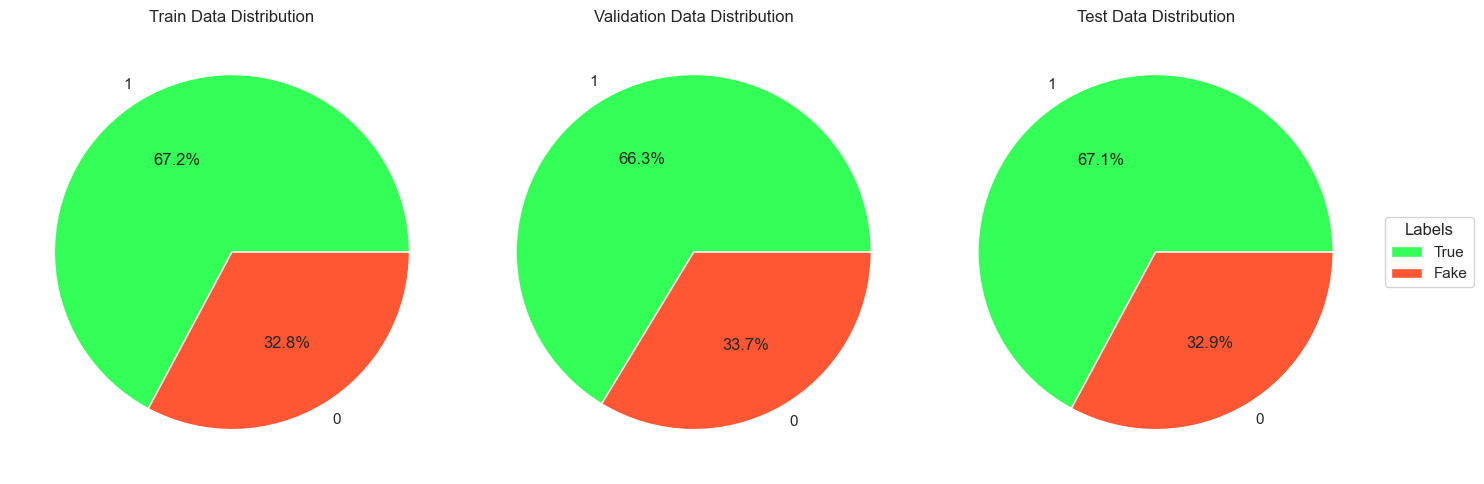

In [51]:
# Get the distribution of the train/test split

# Get label counts for train, validation, and test data
train_label_counts = y_train.value_counts()
val_label_counts = y_val.value_counts()
test_label_counts = y_test.value_counts()

# Define custom colors
colors = ['#33FF57', '#FF5733']

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Train data distribution
wedges, texts, autotexts = axes[0].pie(train_label_counts, labels=train_label_counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Train Data Distribution')

# Subplot 2: Validation data distribution
wedges, texts, autotexts = axes[1].pie(val_label_counts, labels=val_label_counts.index, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Validation Data Distribution')

# Subplot 3: Test data distribution
wedges, texts, autotexts = axes[2].pie(test_label_counts, labels=test_label_counts.index, autopct='%1.1f%%', colors=colors)
axes[2].set_title('Test Data Distribution')

# Add a legend manually
legend_labels = ['True', 'Fake']
axes[2].legend(legend_labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Vectorization

In [52]:
# Create a TextVectorization layer without specifying max_tokens to get the Vocabulary Size

text_vectorizer = TextVectorization(split="whitespace",
                                    output_mode="int")

# Fit the text vectorizer
text_vectorizer.adapt(X)

# Get the number of unique tokens in the vocabulary
vocab_size = len(text_vectorizer.get_vocabulary())

# Print the vocabulary size
print("Vocabulary size:", vocab_size)

Vocabulary size: 85088


In [53]:
# Setup text vectorization with custom variables

# Set the maximum vocabulary size
max_vocab_size = 10000

# Calculate the maximum sequence length based on the average number of tokens in training data
average_tokens_per_sequence = round(sum([len(text.split()) for text in X_train]) / len(X_train))

# Create and configure the TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode="int",
    output_sequence_length=average_tokens_per_sequence,
    pad_to_max_tokens=True
)

# Adapt the TextVectorization layer to the training text
if len(X_train) > 0:
    text_vectorizer.adapt(X_train)
else:
    print("Warning: X_train is empty, adaptation skipped.")

##Embedding

In [54]:
# Create embedding with Keras Layer

tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_size,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=average_tokens_per_sequence)

c:\Users\Shiro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



## Models

### Baseline Model

In [55]:
# Create a Baseline Model using Gridsearch with few parameters

# Define the pipeline with TF-IDF and Multinomial Naive Bayes
baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Define hyperparameters and their possible values for grid search
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'clf__alpha': [0.1, 0.5, 1.0]
}

# Create a grid search object
grid_search = GridSearchCV(baseline_model, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
baseline_best_params = grid_search.best_params_
baseline_best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
baseline_test_accuracy = baseline_best_model.score(X_val, y_val)

print(f"Baseline Model Best Parameters: {baseline_best_params}")
print(f"Baseline Model Test Accuracy: {baseline_test_accuracy*100:.2f}%")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Baseline Model Best Parameters: {'clf__alpha': 0.1, 'tfidf__max_features': 10000}
Baseline Model Test Accuracy: 84.02%


In [56]:
# Make predictions

baseline_prediction = baseline_best_model.predict(X_test)
baseline_prediction[:5]

array([1, 1, 0, 1, 1])

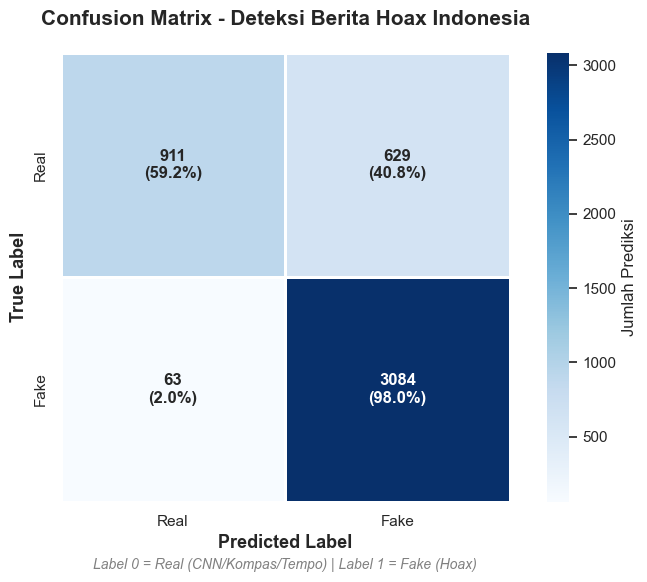


CONFUSION MATRIX ANALYSIS
True Negatives (Real predicted as Real):  911
False Positives (Real predicted as Fake): 629
False Negatives (Fake predicted as Real): 63
True Positives (Fake predicted as Fake):  3,084


In [57]:
# Plot confusion matrix

baseline_cm = plot_confusion_matrix(y_test, baseline_prediction)
baseline_cm

In [59]:
# Define helper to calculate common classification metrics and return as a DataFrame
def calculate_results_as_dataframe(y_true, y_pred, model_name="Model"):
	"""
	Calculate accuracy, precision, recall and f1 and return a single-row DataFrame.
	"""
	# y_true / y_pred can be pandas Series / numpy arrays
	acc = accuracy_score(y_true, y_pred)
	precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
	
	results_df = pd.DataFrame({
		"model": [model_name],
		"accuracy": [acc],
		"precision": [precision],
		"recall": [recall],
		"f1": [f1]
	})
	return results_df

# Show results for baseline
baseline_results = calculate_results_as_dataframe(y_test, baseline_prediction, model_name="Baseline Gridsearch")

baseline_results

,model,accuracy,precision,recall,f1
0,Baseline Gridsearch,0.852358,0.830595,0.979981,0.899125


In [60]:
baseline_results["model"] = "Baseline Gridsearch"
baseline_results["architecture"] = "Multinomial Naive Bayes"
baseline_results["tokenizer/vectorizer"] = "TfidfVectorizer"
baseline_results["embedding"] = "None"

baseline_results

,model,accuracy,precision,recall,f1,architecture,tokenizer/vectorizer,embedding
0,Baseline Gridsearch,0.852358,0.830595,0.979981,0.899125,Multinomial Naive Bayes,TfidfVectorizer,None


### Basic RNN Model

In [66]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

keras_model = tf.keras.Model(inputs, outputs)

# Compile model
keras_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
keras_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 115)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 115, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model

callbacks = [
    ModelCheckpoint(filepath='keras_model', save_best_only=True),  # ← Hapus save_format
    EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
    CSVLogger('keras_training_log.csv')
]

keras_model_history = keras_model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=keras_model

In [ ]:
# Make predictions on input data (X_test) in form of probabilities

keras_probabilities = keras_model.predict(X_test)
keras_probabilities[:5]

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
keras_prediction = tf.squeeze(tf.round(keras_probabilities))
keras_prediction[:10]

In [ ]:
# Plot confusion matrix

keras_cm = plot_confusion_matrix(y_test, keras_prediction)
keras_cm

In [ ]:
# Show results

keras_results = calculate_results_as_dataframe(y_test, keras_prediction)

keras_results

In [ ]:
keras_results["model"] = "Basic Keras"
keras_results["architecture"] = "Basic RNN"
keras_results["tokenizer/vectorizer"] = "TextVectorization"
keras_results["embedding"] = "Keras Layer"

keras_results

### LSTM Model


In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

lstm_model = tf.keras.Model(inputs, outputs)

# Compile model
lstm_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
lstm_model.summary()

In [ ]:
callbacks = [
    ModelCheckpoint(filepath='lstm_model', save_best_only=True),
    EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
    CSVLogger('lstm_training_log.csv')
]

lstm_model_history = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

In [ ]:
# Make predictions on input data (X_test) in form of probabilities

lstm_probabilities = lstm_model.predict(X_test)
lstm_probabilities[:5]

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
lstm_prediction = tf.squeeze(tf.round(lstm_probabilities))
lstm_prediction[:10]

In [ ]:
# Plot confusion matrix

lstm_cm = plot_confusion_matrix(y_test, lstm_prediction)
lstm_cm

In [ ]:
# Show results

lstm_results = calculate_results_as_dataframe(y_test, lstm_prediction)
lstm_results

In [ ]:
lstm_results["model"] = "LSTM"
lstm_results["architecture"] = "LSTM RNN"
lstm_results["tokenizer/vectorizer"] = "TextVectorization"
lstm_results["embedding"] = "Keras Layer"

lstm_results

### LSTM GRU Model

In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)


outputs = layers.Dense(1, activation="sigmoid")(x)

gru_model = tf.keras.Model(inputs, outputs)

# Compile model
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
gru_model.summary()

In [ ]:
callbacks = [
    ModelCheckpoint(filepath='gru_model', save_best_only=True),
    EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss'),
    CSVLogger('gru_training_log.csv')
]

gru_model_history = gru_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

In [ ]:
# Make predictions on input data (X_test) in form of probabilities

gru_probabilities = gru_model.predict(X_test)
gru_probabilities[:5]

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
gru_prediction = tf.squeeze(tf.round(gru_probabilities))
gru_prediction[:10]

In [ ]:
# Plot confusion matrix

gru_cm = plot_confusion_matrix(y_test, gru_prediction)
gru_cm

In [ ]:
# Show results

gru_results = calculate_results_as_dataframe(y_test, gru_prediction)
gru_results

In [ ]:
gru_results["model"] = "GRU"
gru_results["architecture"] = "LSTM GRU RNN"
gru_results["tokenizer/vectorizer"] = "TextVectorization"
gru_results["embedding"] = "Keras Layer"

gru_results

## Models Comparison

In [ ]:
model_comparison = pd.concat([baseline_results, keras_results, lstm_results, gru_results]).sort_values(by="accuracy", ascending=False).set_index("model")

model_comparison

In [ ]:
model_comparison.to_csv('model_comparison.csv')

# Download Best Model

In [ ]:
!zip -r bi_model.zip /content/bi_model

In [ ]:
files.download('bi_model.zip')